TK

In [ ]:
# reading in files from google drive to speed up run time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Loading dependencies

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811680 sha256=3298e90ba56c27a3989303a29111660827fe2f603ef0510a9e7c145864acfb89
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import surprise
from surprise.prediction_algorithms import *
from surprise import Reader, Dataset


from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

import datetime as dt

import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy import create_engine, text
import sqlite3

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create the engine to connect to the inbuilt
# sqllite database
engine = create_engine("sqlite+pysqlite:///:memory:")

## Reading in the tables

###Dataframes

In [ ]:
movies_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase4-Project-Data/movies.csv")

In [ ]:
ratings_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase4-Project-Data/ratings.csv")

###SQL

In [ ]:
movies_df.to_sql('movies', con=engine, if_exists='replace')

9742

In [ ]:
ratings_df.to_sql('ratings', con=engine, if_exists='replace')

100836

##Creating a naive baseline model

If our model predicted the mean rating for every user it would be off by 1 point on average.  

In [ ]:
stats = ratings_df[['rating']].describe()
stats

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [ ]:
# sanity check
mean_rating = 3.5
rmse_naive = np.sqrt(((ratings_df['rating'] - mean_rating) ** 2).mean())
print(rmse_naive)

1.0425252322754481


## Model Iterations using `surprise`

In [ ]:
#Creating a surprise compatible dataframe
query = \
"""
SELECT userID, movieID, rating
FROM ratings;
"""
df_ratings_surprise = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
# read in values as Surprise dataset
reader = Reader()
data = Dataset.load_from_df(df_ratings_surprise, reader)


###Using `GridSearchCV` to find the best parameters

The SVD model using the recommended parameters below would still be off by almost .88 on average. A slight improvement over the baseline.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_factors':[100,200],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Print best RMSE score
print(gs.best_score["rmse"])

# Print optimal parameters
print(gs.best_params['rmse'])



0.8801705611921447
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
gs.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7a165022dc00>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7a165022d720>}

In [ ]:
gs.best_score

{'rmse': 0.8801705611921447, 'mae': 0.6798103844705621}

In [ ]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [ ]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.96770592, 0.97346823, 0.97462035, 0.97108379, 0.97270936]))
('test_mae', array([0.74309039, 0.75316883, 0.75403615, 0.75290956, 0.74932861]))
('fit_time', (0.322650671005249, 0.410550594329834, 0.29779767990112305, 0.25770020484924316, 0.27564144134521484))
('test_time', (2.191000461578369, 2.1428210735321045, 2.141496181488037, 2.1196348667144775, 1.0613243579864502))
-----------------------
0.9719175295290612


In [ ]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.87225911, 0.87668982, 0.87140957, 0.87789859, 0.88128406]))
('test_mae', array([0.66640913, 0.66965854, 0.66512501, 0.66917807, 0.67263651]))
('fit_time', (0.5770218372344971, 0.5812499523162842, 0.5814487934112549, 0.582007884979248, 0.6076419353485107))
('test_time', (1.6663703918457031, 1.6378793716430664, 1.6174218654632568, 1.7325451374053955, 1.7101109027862549))
-----------------------
0.8759082283304863


In [ ]:
 #Split data into "train-validation set" and "test set"
train, test = surprise.model_selection.train_test_split(data,test_size=0.25, random_state=42)

In [ ]:
# Train a final model on the "train-validation set" with the best found parameters
final_model = SVD(**gs.best_params['rmse'])
final_model.fit(train)

# test model on the "test set"
predictions = final_model.test(test)

In [ ]:
surprise.accuracy.mae(final_model.test(test))

MAE:  0.6838


0.6838063237473588

In [ ]:
surprise.accuracy.rmse(final_model.test(test))

RMSE: 0.8856


0.8855536337358373

###Modeling off a dataset that filters out "superusers"

####Visualizing distribution of ratings

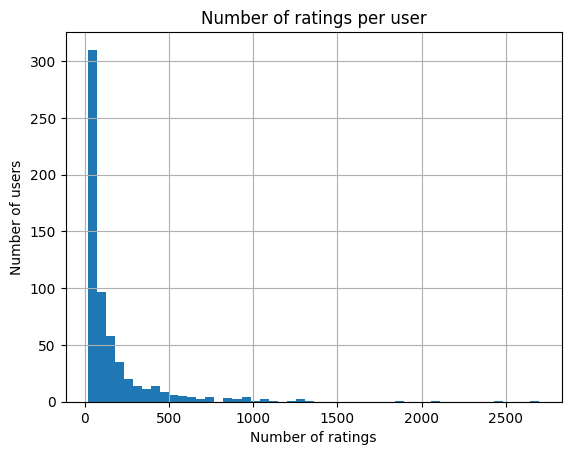

In [ ]:
ratings_per_user = ratings_df.groupby('userId').size()
ratings_per_user.hist(bins=50)
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show();


####Determining the impact of filtering on dataset size

In [ ]:
for threshold in [50, 70, 100, 200, 500, 1000]:
    print(f"Threshold: {threshold}")
    print(f"Number of users: {sum(ratings_per_user <= threshold)}")
    print(f"Number of ratings: {ratings_per_user[ratings_per_user <= threshold].sum()}")
    print()


Threshold: 50
Number of users: 232
Number of ratings: 7374

Threshold: 70
Number of users: 305
Number of ratings: 11707

Threshold: 100
Number of users: 365
Number of ratings: 16823

Threshold: 200
Number of users: 477
Number of ratings: 32552

Threshold: 500
Number of users: 567
Number of ratings: 60782

Threshold: 1000
Number of users: 598
Number of ratings: 82319



###Model Iteration: Filtering out users who submitted > 500 ratings

In [ ]:
# Calculate the number of ratings made by each user
ratings_per_user = ratings_df.groupby('userId').size()

# Define your threshold for a superuser. This is something we might adjust.
# In this example, we're assuming anyone who's rated more than 500 movies is a superuser.
superuser_threshold = 500

# Identify the superusers
superusers = ratings_per_user[ratings_per_user > superuser_threshold].index

# Filter out the superusers
superusers_filtered_out_df = ratings_df[~ratings_df.userId.isin(superusers)]


In [ ]:
superusers_filtered_out_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
new_df = superusers_filtered_out_df.drop(columns='timestamp')

In [ ]:
new_df['rating'].describe()

count    60782.000000
mean         3.636035
std          1.055376
min          0.500000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [ ]:
# read in values as Surprise dataset
reader = Reader()
data_filtered = Dataset.load_from_df(new_df, reader)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_factors':[100,200],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, measures=['rmse', 'mae'], cv=5)
gs.fit(data_filtered)

# Print best RMSE score
print(gs.best_score["rmse"])

# Print optimal parameters
print(gs.best_params['rmse'])


0.9163277755994246
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
gs.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7a16510c4a60>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7a165e9727a0>}

In [ ]:
gs.best_score

{'rmse': 0.9163277755994246, 'mae': 0.7044672113316377}

In [ ]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data_filtered, n_jobs=-1)

In [ ]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([1.03938278, 1.03996795, 1.0406508 , 1.03906281, 1.05211091]))
('test_mae', array([0.79656551, 0.79549625, 0.79870357, 0.79615798, 0.80586285]))
('fit_time', (0.20669150352478027, 0.15058517456054688, 0.2545502185821533, 0.21057343482971191, 0.15060853958129883))
('test_time', (1.2254860401153564, 1.2114894390106201, 1.1772067546844482, 1.0567638874053955, 0.6266775131225586))
-----------------------
1.0422350487200278


In [ ]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data_filtered)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.92523554, 0.94608427, 0.936298  , 0.93510161, 0.93903489]))
('test_mae', array([0.70714975, 0.72048549, 0.71295677, 0.71034407, 0.71027235]))
('fit_time', (0.30255937576293945, 0.3054077625274658, 0.29456138610839844, 0.2875080108642578, 0.3163614273071289))
('test_time', (0.8564589023590088, 0.856318473815918, 0.8644382953643799, 0.8882730007171631, 0.8884439468383789))
-----------------------
0.9363508616754166


In [ ]:
 #Split data into "train-validation set" and "test set"
train, test = surprise.model_selection.train_test_split(data_filtered,test_size=0.25, random_state=42)

In [ ]:
# Train a final model on the "train-validation set" with the best found parameters
final_model_nosupers = SVD(**gs.best_params['rmse'])
final_model_nosupers.fit(train)

# Finally, test your model on the "test set"
predictions = final_model_nosupers.test(test)

In [ ]:
surprise.accuracy.mae(final_model_nosupers.test(test))

MAE:  0.7065


0.7064666331147774

In [ ]:
surprise.accuracy.rmse(final_model_nosupers.test(test))

RMSE: 0.9213


0.9213493597922996

####Visualizing ratings distribution with superusers (> 500 ratings) filtered out

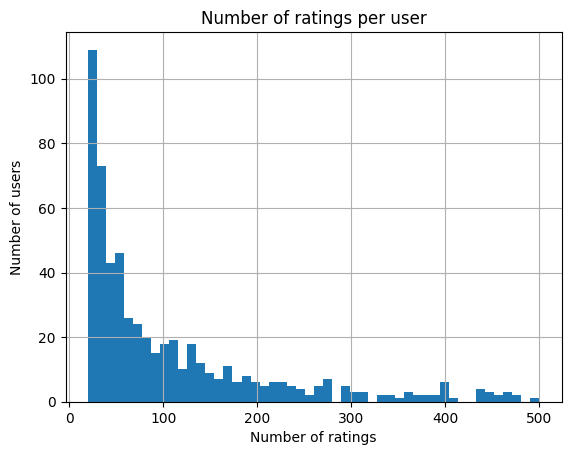

In [ ]:
ratings_per_user = new_df.groupby('userId').size()
ratings_per_user.hist(bins=50)
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show();

###Model Iteration: Filtering out users who submitted > 1000 ratings

In [ ]:
# Calculate the number of ratings made by each user
ratings_per_user = ratings_df.groupby('userId').size()

# Define your threshold for a superuser. This is something we might adjust.
# In this example, we're assuming anyone who's rated more than 500 movies is a superuser.
superuser_threshold = 1000

# Identify the superusers
superusers = ratings_per_user[ratings_per_user > superuser_threshold].index

# Filter out the superusers
superusers_1000_filtered_out_df = ratings_df[~ratings_df.userId.isin(superusers)]


In [ ]:
superusers_1000_filtered_out_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
new_df2 = superusers_1000_filtered_out_df.drop(columns='timestamp')

In [ ]:
new_df2['rating'].describe()

count    82319.000000
mean         3.554410
std          1.058603
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [ ]:
# read in values as Surprise dataset
reader = Reader()
data_filtered2 = Dataset.load_from_df(new_df2, reader)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_factors':[100,200],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, measures=['rmse', 'mae'], cv=5)
gs.fit(data_filtered2)

# Print best RMSE score
print(gs.best_score["rmse"])

# Print optimal parameters
print(gs.best_params['rmse'])


0.9059846042979431
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
gs.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7cf5a7c8b310>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7cf5a7c8b520>}

In [ ]:
gs.best_score

{'rmse': 0.9059846042979431, 'mae': 0.6981376784511697}

In [ ]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data_filtered2, n_jobs=-1)

In [ ]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([1.01112908, 1.01915251, 1.02028979, 1.00503899, 1.00995696]))
('test_mae', array([0.78196756, 0.78474796, 0.78607098, 0.76866008, 0.77825491]))
('fit_time', (0.25490331649780273, 0.27951860427856445, 0.28783178329467773, 0.3176450729370117, 0.20505380630493164))
('test_time', (1.783658742904663, 1.8534595966339111, 1.8467507362365723, 1.7464244365692139, 0.9496080875396729))
-----------------------
1.0131134645860804


In [ ]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data_filtered2)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.91877178, 0.90614381, 0.92007174, 0.90444039, 0.91458524]))
('test_mae', array([0.69914554, 0.69205456, 0.70374846, 0.69083309, 0.69451633]))
('fit_time', (0.6199042797088623, 0.4892101287841797, 0.49657320976257324, 0.4812886714935303, 0.4863317012786865))
('test_time', (1.2706611156463623, 1.3804986476898193, 1.351897954940796, 1.4507167339324951, 1.2670159339904785))
-----------------------
0.9128025933527258


In [ ]:
 #Split data into "train-validation set" and "test set"
train, test = surprise.model_selection.train_test_split(data_filtered2,test_size=0.25, random_state=42)

In [ ]:
# Train a final model on the "train-validation set" with the best found parameters
final_model_no_1000_supers = SVD(**gs.best_params['rmse'])
final_model_no_1000_supers.fit(train)

# Finally, test your model on the "test set"
predictions = final_model_no_1000_supers.test(test)

In [ ]:
surprise.accuracy.mae(final_model_no_1000_supers.test(test))

MAE:  0.6940


0.6940342962854683

In [ ]:
surprise.accuracy.rmse(final_model_no_1000_supers.test(test))

RMSE: 0.8998


0.8998120819192612

####Visualizing ratings distribution with superusers (> 1000 ratings) filtered out

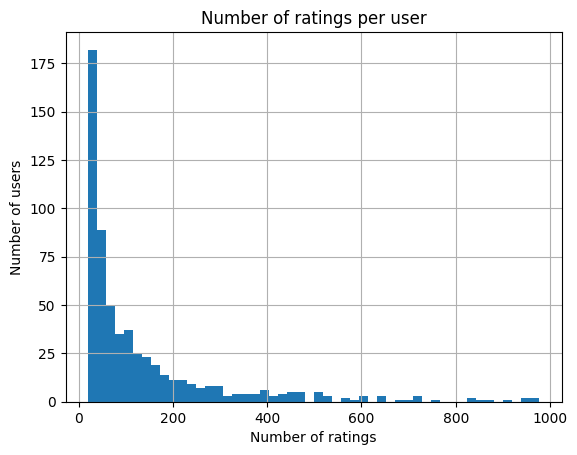

In [ ]:
ratings_per_user = new_df2.groupby('userId').size()
ratings_per_user.hist(bins=50)
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show();

##Final Model: XGBoost

In [ ]:
# Create variable for average rating
global_bias = df_ratings_surprise['rating'].mean()

# Create variables for user bias (how much user's mean rating deviates from the overall mean (3.5))
# and item bias (how much a movie's mean rating differs from the overall mean (3.5))
df_user_bias = df_ratings_surprise.groupby('userId')['rating'].mean() - global_bias
df_item_bias = df_ratings_surprise.groupby('movieId')['rating'].mean() - global_bias

# add biases to DataFrame
df = df_ratings_surprise.join(df_user_bias, on='userId', rsuffix='_user_bias')
final_df = df.join(df_item_bias, on='movieId', rsuffix='_item_bias')


In [ ]:
# create X and y variables
X = final_df.drop(['rating'], axis=1)
y = final_df['rating']

# create a DMatrix (the recommended input for xgboost models)
data_dmatrix = xgb.DMatrix(data=X, label=y)

# define the parameters for the xgboost model
params = {"objective":'reg:squarederror', 'random_state':42}

# call the cv function
# cv_results contains train and test RMSE metrics for each boosting round
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)


In [ ]:
# find the best number of boosting rounds
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
best_num_rounds

67

In [ ]:
# train the xgboost model with the best number of boosting rounds
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=best_num_rounds)

# save this model for later use
xg_reg.save_model('my_model.json')

In [ ]:
#export model

model_save_name = 'my_model.json'
path = F"/content/gdrive/My Drive/my_model.json"

xg_reg.save_model(path)

###Evaluating the model

In [ ]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
63,0.751374,0.001166,0.789902,0.003784
64,0.750882,0.001247,0.789799,0.003778
65,0.750590,0.001357,0.789791,0.003742
66,0.750127,0.001304,0.789800,0.003780
67,0.749650,0.001182,0.789784,0.003781


In [ ]:
mae = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=10, metrics="mae", as_pandas=True, seed=42)
mae.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
76,0.565119,0.000846,0.597352,0.001671
77,0.564749,0.000816,0.597349,0.001696
78,0.564479,0.000756,0.597311,0.001679
79,0.564080,0.000749,0.597300,0.001719
80,0.563664,0.000724,0.597267,0.001726


####Feature Importance
Number of splits across all the trees in our model:
* `'userId'`: 816
* `'movieId'`: 1092
* `'rating_user_bias'`: 829
* `'rating_item_bias'`: 983

In [ ]:
print(xg_reg.get_score(importance_type='weight')) # or 'gain' or 'cover'


{'userId': 816.0, 'movieId': 1092.0, 'rating_user_bias': 829.0, 'rating_item_bias': 983.0}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

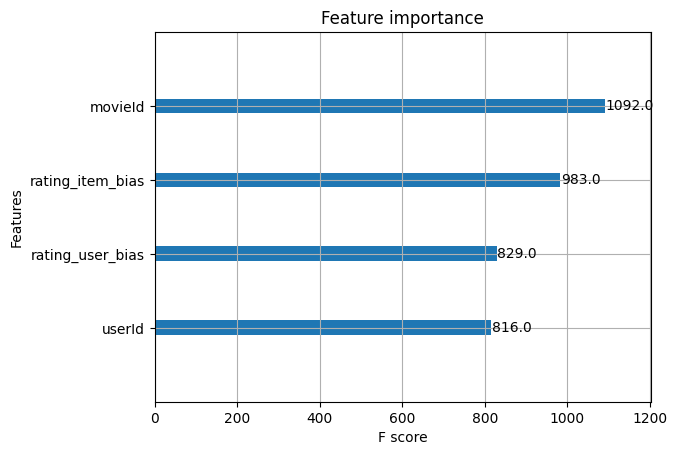

In [ ]:
xgb.plot_importance(xg_reg)